In [10]:
#Libraries - all required except plt (just for checking and visualization) and mp (for viewing final model)
import matplotlib.pyplot as plt
import numpy as np
import triangle as tr
import meshio
import meshplot as mp
import json
import subprocess
import colorsys

In [11]:
#FUNCTION DEFINITIONS

#================================================================================

#Forms lists necessary for further work - inefficient, probably needs some fixing
#This function is specifically for if you're NOT doing dual-side colours
def build_point_lists(v, pts, seg0, e=-1):
    segment_lines = []
    all_dots = []
    all_dots_indexed = {}
    red_dots = []
    green_dots = []
    segment_green_points = {}
    
    for line in seg0:
        segment_lines.append([pts[line[0]], pts[line[1]]])
        
    for point in pts:
        p = [point[0], point[1]]
        red_dots.append(p)
        all_dots.append(p)
    
    gdi = []
    for p_i in range(len(v)):
        p = v[p_i].tolist()
        if p not in red_dots:
            for line_index in range(len(segment_lines)):
                if solve([segment_lines[line_index][0], p, segment_lines[line_index][1]]):
                    green_dots.append(p)
                    gdi.append([p[0], p[1], p_i])
                    all_dots.append(p)
                    all_dots_indexed[p_i] = p
                    break
        else:
            all_dots_indexed[p_i] = p
            
    for p_i in range(len(gdi)):
        p = gdi[p_i]
        if e == -1 or p[2] < e:
            for line_index in range(len(segment_lines)):
                if solve([segment_lines[line_index][0], green_dots[p_i], segment_lines[line_index][1]]):
                    if line_index in segment_green_points:
                        segment_green_points[line_index].append((green_dots[p_i][0], green_dots[p_i][1], p_i + len(red_dots)))
                    else:
                        segment_green_points[line_index] = [(green_dots[p_i][0], green_dots[p_i][1], p_i + len(red_dots))]
                    break
        else:
            for line_index in range(len(segment_lines)-1, -1, -1):
                if solve([segment_lines[line_index][0], green_dots[p_i], segment_lines[line_index][1]]):
                    if line_index in segment_green_points:
                        segment_green_points[line_index].append((green_dots[p_i][0], green_dots[p_i][1], p_i + len(red_dots)))
                    else:
                        segment_green_points[line_index] = [(green_dots[p_i][0], green_dots[p_i][1], p_i + len(red_dots))]
                    break
    
    return (segment_lines, all_dots, all_dots_indexed, red_dots, green_dots, segment_green_points)


#Helper function for solve() - determines if a float is between two other floats
def is_between(num, n1, n2):
    if (num <= n1 and num >= n2) or (num >= n1 and num <= n2):
        return True
    else:
        return False

    
#function that determines if a point is between two other points on the same segment
def solve(coordinates) -> bool:
    (x0, y0), (x2, y2) = coordinates[0], coordinates[2]
    x1, y1 = coordinates[1]
    if (abs((x0 - x2) * (y2 - y1) - (x2 - x1) * (y0 - y2)) < 0.001) and (is_between(x1, x0, x2) and is_between(y1, y0, y2)):
        return True
    else:
        return False


#Is Pc left of the line formed by P0 and P1 ('left' being relative to the orientation of the line)
def is_left(P0, P1, Pc):
    res = (P1[0] - P0[0]) * (Pc[1] - P0[1]) - (Pc[0] - P0[0]) * (P1[1] - P0[1])
    return res > 0

#Helper function for intersect (I grabbed this one off of a forum somewhere tbh idk how it works)
def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

# Return true if lines l1 and l2 intersect
def intersect(l1, l2):
    A = l1[0]
    B = l1[1]
    C = l2[0]
    D = l2[1]
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

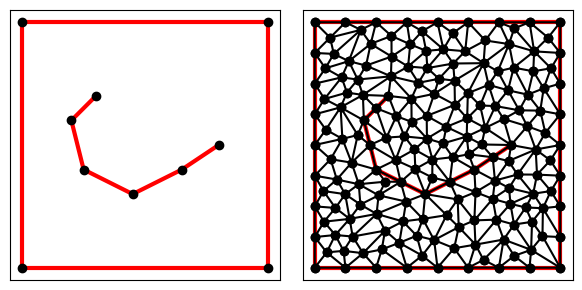

In [12]:
#FORMING BASE MESH FROM TRIANGLE

#================================================================================

#Forming the object (manually)
pts0 = np.array(((0, 0), (10, 0), (10, 10), (0, 10))) #border
#pts1 = np.array(((3, 7), (2.675, 6.88), (2.38, 6.65), (2.15, 6.33), (2, 6), (1.9, 5.5), (2, 5), (2.1, 4.5), (2.4, 4), (2.75, 3.5), (3.25, 3.1), (3.85, 2.85), (4.5, 2.8), (5.13, 2.89), (5.7, 3.2), (6.15, 3.58), (6.5, 4), (6.8, 4.45), (7, 5)))
pts1 = np.array(((3, 7), (2, 6), (2.5, 4), (4.5, 3), (6.5, 4), (8, 5))) 

pts = np.vstack([pts0, pts1]) #combined

#connecting points together (manually)
seg1 = np.array(((0, 1), (1, 2), (2, 3), (3, 0)))
seg2 = []
for i in range(4, len(pts1) + 3):
    seg2.append((i, i+1))
seg2 = np.array(seg2)
seg_comb = [seg1, seg2]
seg0 = np.vstack(seg_comb)

#indicies where segment meets up with beginning of shape--needed for colour generation
#loop_backs = [3, 39]
loop_backs = [3, 13]
#indicies where segments are isolated--needed for colour generation
iso_segs = []

#form mesh
A = dict(vertices=pts, segments=seg0)
meshObj = tr.triangulate(A, 'qpa0.5')
shape = (pts, seg0, meshObj, loop_backs, iso_segs)
tr.compare(plt, A, meshObj)

In [13]:
#ESTABLISHING VARIABLES FOR IMPORTANT VERTEX/SEGMENT ARRAYS

#================================================================================

#Grab all necessary lists of vertexes and mapped segements
lists = build_point_lists(meshObj['vertices'], pts.tolist(), seg0.tolist())
segment_lines = lists[0]
all_dots = lists[1]
all_dots_indexed = lists[2]
red_dots = lists[3]
green_dots = lists[4]
segment_green_points = lists[5]

In [14]:
#Grab every vertex that is in the drawn polyline
seg_vs = [k for k, v in all_dots_indexed.items() if (v[0] != 0 and v[0] != 10 and v[1] != 0 and v[1] != 10)]

#Grab every triangle that contains one or more of any of the vertices in the array created above
seg_tris = []
for tri in range(len(meshObj['triangles'])):
    for v in meshObj['triangles'][tri]:
        if v in seg_vs:
            t = meshObj['triangles'][tri].tolist()
            t.append(tri)
            seg_tris.append(t)
            continue

#Collect all segment lines that involve the points in seg_vs
red_lines = []
for mesh_v in seg_vs: 
    for s in range(len(meshObj['segments'])): 
        seg = meshObj['segments'][s].tolist()
        if mesh_v in seg: 
            sg = seg.copy()
            if sg not in red_lines: 
                red_lines.append(sg)

#Sort segments from start to finish
red_lines_copy = red_lines.copy()
red_lines_ordered = []
sg = red_lines_copy.pop(0)
sg.sort()
red_lines_ordered.append(sg)
cur_index = 0
while len(red_lines_copy) > 0:
    line_bef = red_lines_ordered[cur_index]
    for pt in line_bef:
        line = 0
        while line < len(red_lines_copy):
            if pt in red_lines_copy[line]:
                s = red_lines_copy.pop(line)
                s.sort()
                red_lines_ordered.append(s)
                line = len(red_lines_copy) + 1
            line += 1
    cur_index += 1

#Remake seg_vs but ordered from start to finish 
seg_vs_ordered = []
for line in red_lines_ordered:
    for pt in line:
        if pt not in seg_vs_ordered:
            seg_vs_ordered.append(pt)

#Grab the 'neighbourhoods' of triangles around every point in seg_vs except for the start and end
#(Clarification - neighbourhood = every triangle that contains at least one vertex in seg_vs) 
rings = []
for mesh_v in range(1, len(seg_vs_ordered)-1):
    rings.append([])
    rings[mesh_v-1].append(seg_vs_ordered[mesh_v])
    for tri in seg_tris:
        if seg_vs_ordered[mesh_v] in tri[:3]:
            t = tri.copy()
            if t not in rings[mesh_v-1]:
                rings[mesh_v-1].append(t)

#Take first ring
ring = rings[0]
center = ring[0]
#Determine what segment this ring is on
reds = []
for line in red_lines_ordered:
    if center in line:
        reds.append(line)
seg = []
for line in reds:
    for pt in line:
        if pt != center and pt not in seg:
            seg.append(pt)
seg.sort()

#Take first triangle, find middle point, determine what side of the segment it belongs to it is on, append bool
first_tri = ring[1]
first_tri_center = [((meshObj['vertices'][first_tri[0]][0] + meshObj['vertices'][first_tri[1]][0] + meshObj['vertices'][first_tri[2]][0]) / 3), ((meshObj['vertices'][first_tri[0]][1] + meshObj['vertices'][first_tri[1]][1] + meshObj['vertices'][first_tri[2]][1]) / 3)]
first_tri.append(is_left(meshObj['vertices'][seg[0]], meshObj['vertices'][seg[1]], first_tri_center))
#Iterate through every triangle -- if the middle point of the triangle is across a line from the
#first triangle's middle point, append opposite bool. Otherwise, append same bool.
for tri in ring[2:]:
    tri_center = [((meshObj['vertices'][tri[0]][0] + meshObj['vertices'][tri[1]][0] + meshObj['vertices'][tri[2]][0]) / 3), ((meshObj['vertices'][tri[0]][1] + meshObj['vertices'][tri[1]][1] + meshObj['vertices'][tri[2]][1]) / 3)]
    ref_segment = [first_tri_center, tri_center]
    num_intersects = 0
    for seg in segment_lines:
        if intersect(ref_segment, seg):
            num_intersects += 1
    if num_intersects % 2 == 0:
        tri.append(first_tri[4])
    else:
        tri.append(not first_tri[4])

#Loop through all other rings and find any common triangles from first ring to append bool to
#INNEFFICIENT, RINGS ARE ALREADY SORTED, COULD JUST DO NEXT RING
for tri in ring[1:]:
    t = tri[:3]
    r = rings[1]
    for rt in range(1, len(r)):
             if r[rt][:3] == t:
                    r[rt] = tri

#repeat process for every other ring in rings
for r_index in range(1, len(rings)):
    r = rings[r_index]
    center = r[0]
    reds = []
    for line in red_lines_ordered:
        if center in line:
            reds.append(line)
    #instead of making first_tri the first triangle, it's the first triangle that has a bool appended to it
    first_tri = None
    for tri in r[1:]:
        if len(tri) == 5:
            first_tri = tri
            break
    first_tri_center = [((meshObj['vertices'][first_tri[0]][0] + meshObj['vertices'][first_tri[1]][0] + meshObj['vertices'][first_tri[2]][0]) / 3), ((meshObj['vertices'][first_tri[0]][1] + meshObj['vertices'][first_tri[1]][1] + meshObj['vertices'][first_tri[2]][1]) / 3)]
    for tri in r[1:]:
        if len(tri) < 5:
            tri_center = [((meshObj['vertices'][tri[0]][0] + meshObj['vertices'][tri[1]][0] + meshObj['vertices'][tri[2]][0]) / 3), ((meshObj['vertices'][tri[0]][1] + meshObj['vertices'][tri[1]][1] + meshObj['vertices'][tri[2]][1]) / 3)]
            ref_segment = [first_tri_center, tri_center]
            num_intersects = 0
            for seg in segment_lines:
                if intersect(ref_segment, seg):
                    num_intersects += 1
            if num_intersects % 2 == 0:
                tri.append(first_tri[4])
            else:
                tri.append(not first_tri[4])
    
    if r_index < len(rings) - 1:
        for tri in r[1:]:
            t = tri[:3]
            ri = rings[r_index + 1]
            for rt in range(1, len(ri)):
                     if ri[rt][:3] == t:
                            ri[rt] = tri


#Store all triangles in one array, not sorted by ring
tris_side_mapped_bool = []

for ring in rings:
    for tri in ring[1:]:
        if tri not in tris_side_mapped_bool:
            tris_side_mapped_bool.append(tri)

#Generate a second polyline identical to the first, append vertices to remap left-aligned triangles to
seg_vs_ordered_alt = []
second_polyline = []
svo = seg_vs_ordered[1:-1]
for v in svo:
    seg_vs_ordered_alt.append([v])
for i in range(len(seg_vs_ordered_alt)):
    seg_vs_ordered_alt[i].append(i+len(meshObj['vertices']))
    second_polyline.append(i + len(meshObj['vertices']))

#Remap left-aligned triangles to second polyline
tris_side_mapped = []

for tri in tris_side_mapped_bool:
    if tri[4]:
        new_tri = []
        for v in tri[:3]:
            if v in svo:
                for v_p in seg_vs_ordered_alt:
                    if v_p[0] == v:
                        new_tri.append(v_p[1])
            else:
                new_tri.append(v)
        new_tri.append(tri[3])
        tris_side_mapped.append(new_tri)
    else:
        tris_side_mapped.append(tri[:4])

#Adds a duplicated polyline to map left-aligned tris to
temp_verts = meshObj['vertices'].tolist()
temp_vms = meshObj['vertex_markers'].tolist()
len_before = len(temp_verts)
for v in svo:
    if v < len(red_dots):
        temp_verts.insert(len(red_dots), meshObj['vertices'][v].tolist())
        temp_vms.insert(len(red_dots), meshObj['vertex_markers'][v].tolist())
        len_before += 1
    else:
        temp_verts.append(meshObj['vertices'][v].tolist())
        temp_vms.append(meshObj['vertex_markers'][v].tolist())
meshObj['vertices'] = np.array(temp_verts)
meshObj['vertex_markers'] = np.array(temp_vms)

#Replace triangles in meshObj with left-aligned triangles that have been remapped
for tri in tris_side_mapped:
    meshObj['triangles'][tri[3]] = tri[:3]

second_p_segs = meshObj['segments'].tolist()
mesh_seg_m = meshObj['segment_markers'].tolist()
second_p_segs.append([svo[-1], second_polyline[-1]])
mesh_seg_m.append([1])
for p in range(len(second_polyline)-1, 0, -1):
    second_p_segs.append([second_polyline[p], second_polyline[p-1]])
    mesh_seg_m.append([1])
second_p_segs.append([second_polyline[0], svo[0]])
mesh_seg_m.append([1])
meshObj['segments'] = np.array(second_p_segs)
meshObj['segment_markers'] = np.array(mesh_seg_m)

spu = []
for v in svo:
    if v < len(red_dots):
        ind = 2 * len(red_dots) - v - 2
        spu.append(ind)
spu.reverse()
spu_length = len(spu)
second_polyline_updated = []
sp_reds = []
sp_greens = []
for i in range(len(second_polyline)):
    v = svo[i]
    if v < len(red_dots):
        r = spu.pop()
        second_polyline_updated.append(r)
        sp_reds.append(r)
    else:
        second_polyline_updated.append(second_polyline[i])
        sp_greens.append(second_polyline[i])

ma = max(sp_reds)
mi = -1
if len(sp_greens) > 0:
    mi = min(sp_greens)

count = 0
for i in range(len(second_polyline_updated)):
    if second_polyline_updated[i] >= mi:
        second_polyline_updated[i] += len(sp_reds) - count
    else:
        count += 1

mesh_tris = meshObj['triangles'].tolist()
for tri in mesh_tris:
    for i in range(len(tri)):
        if tri[i] in second_polyline:
            for j in range(len(second_polyline)):
                if tri[i] == second_polyline[j]:
                    tri[i] = second_polyline_updated[j]
                    break
        elif tri[i] >= len(red_dots):
            tri[i] += len(sp_reds)
            
mesh_segs = meshObj['segments'].tolist()
for s in mesh_segs:
    for i in range(len(s)):
        if s[i] in second_polyline:
            for j in range(len(second_polyline)):
                if s[i] == second_polyline[j]:
                    s[i] = second_polyline_updated[j]
                    break
        elif s[i] >= len(red_dots):
            s[i] += len(sp_reds)

meshObj['segments'] = np.array(mesh_segs)
meshObj['triangles'] = np.array(mesh_tris)

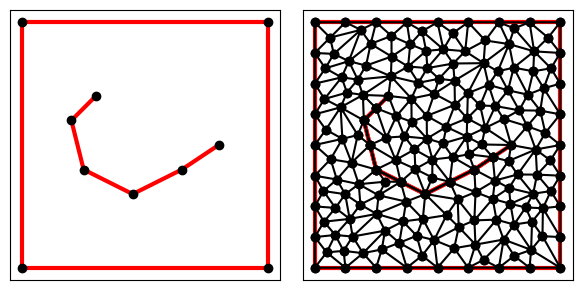

In [15]:
tr.compare(plt, A, meshObj)

In [16]:
pts = pts.tolist()
for p in range(len(pts1)-2, 0, -1):
    pts.append(pts1[p].tolist())

seg0 = seg0.tolist()

n = seg0[-1][-1]
for i in range(seg0[-1][-1], seg0[-1][-1] + len(pts1) - 2):
    seg0.append([i, i+1])
    n = i + 1
seg0.append([n, seg_vs_ordered[0]])

lists = build_point_lists(meshObj['vertices'], pts, seg0, e=len_before)
segment_lines = lists[0]
all_dots = lists[1]
all_dots_indexed = lists[2]
red_dots = lists[3]
green_dots = lists[4]
segment_green_points = lists[5]

In [17]:
segment_green_points

{3: [(0.0, 5.0, 14),
  (0.0, 7.5, 15),
  (0.0, 6.25, 18),
  (0.0, 2.5, 19),
  (0.0, 8.75, 21),
  (0.0, 3.75, 39),
  (0.0, 1.25, 40)],
 4: [(2.5, 6.5, 16)],
 5: [(2.25, 5.0, 17)],
 2: [(5.0, 10.0, 20),
  (2.5, 10.0, 22),
  (3.75, 10.0, 23),
  (7.5, 10.0, 25),
  (1.25, 10.0, 26),
  (6.25, 10.0, 27),
  (8.75, 10.0, 30)],
 1: [(10.0, 7.5, 24),
  (10.0, 5.0, 29),
  (10.0, 2.5, 31),
  (10.0, 6.25, 32),
  (10.0, 3.75, 36),
  (10.0, 8.75, 42),
  (10.0, 1.25, 45)],
 8: [(7.25, 4.5, 28)],
 7: [(5.5, 3.5, 33)],
 0: [(5.0, 0.0, 34),
  (7.5, 0.0, 35),
  (6.25, 0.0, 38),
  (2.5, 0.0, 41),
  (3.75, 0.0, 43),
  (8.75, 0.0, 44),
  (1.25, 0.0, 46)],
 6: [(3.5, 3.5, 37)],
 13: [(2.5, 6.5, 47)],
 12: [(2.25, 5.0, 48)],
 11: [(3.5, 3.5, 49)],
 10: [(5.5, 3.5, 50)],
 9: [(7.25, 4.5, 51)]}

In [7]:
rgb_segs = []
                
#Generate RANDOM rgb values for manually plotted points
def random_colours(rgb_segs):
    random_colour1 = np.random.randint(2), np.random.randint(2), np.random.randint(2)
    while random_colour1 == (0, 0, 0) or random_colour1 == (1, 1, 1):
        random_colour1 = np.random.randint(2), np.random.randint(2), np.random.randint(2)
    random_colour2 = np.random.randint(2), np.random.randint(2), np.random.randint(2)
    while random_colour2 == (0, 0, 0) or random_colour2 == (1, 1, 1):
        random_colour2 = np.random.randint(2), np.random.randint(2), np.random.randint(2)
    segm = [(segment_lines[0][0][0], segment_lines[0][0][1]), (segment_lines[0][1][0], segment_lines[0][1][1])]
    rgb_segs.append({"segment": segm, "colours": [random_colour1, random_colour2]})

    for segment_index in range(1, len(segment_lines)):
        random_colour = np.random.randint(2), np.random.randint(2), np.random.randint(2)
        while random_colour == (0, 0, 0) or random_colour == (1, 1, 1):
            random_colour = np.random.randint(2), np.random.randint(2), np.random.randint(2)
        segm = [(segment_lines[segment_index][0][0], segment_lines[segment_index][0][1]), (segment_lines[segment_index][1][0], segment_lines[segment_index][1][1])]
        rgb_segs.append({"segment": segm, "colours": [rgb_segs[segment_index - 1]["colours"][1], random_colour]})
    
    if len(loop_backs) > 0:
        rgb_segs[loop_backs[0]]['colours'][1] = rgb_segs[0]['colours'][0]
        for loop_num_i in range(1, len(loop_backs)):
            rgb_segs[loop_backs[loop_num_i]]['colours'][1] = rgb_segs[loop_backs[loop_num_i - 1]+1]['colours'][0]

#Generate MANUALLY PLOTTED rgb values for manually plotted points
def fixed_colours(rgb_segs, cols):    
    for i in range(len(segment_lines)):
        segm = [(segment_lines[i][0][0], segment_lines[i][0][1]), (segment_lines[i][1][0], segment_lines[i][1][1])]
        if i < len(segment_lines) - 1:
            rgb_segs.append({"segment": segm, "colours": [cols[i], cols[i+1]]})
        else:
            rgb_segs.append({"segment": segm, "colours": [cols[i], cols[0]]})
        
    rgb_segs[loop_backs[0]]['colours'][1] = rgb_segs[0]['colours'][0]
    for loop_num_i in range(1, len(loop_backs)):
        rgb_segs[loop_backs[loop_num_i]]['colours'][1] = rgb_segs[loop_backs[loop_num_i - 1]+1]['colours'][0]

In [8]:
#random_colours(rgb_segs)

cols = [(1, 1, 1), (1, 1, 1), (1, 1, 1), (1, 1, 1), (0.07450980392, 0.58039215686, 0.10196078431), (0.07450980392, 0.58039215686, 0.10196078431), (0.07450980392, 0.58039215686, 0.10196078431), (0.07450980392, 0.58039215686, 0.10196078431), (0.07450980392, 0.58039215686, 0.10196078431), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1)]
#cols = [(196/255, 91/255, 10/255), (196/255, 91/255, 10/255), (64/255, 49/255, 97/255), (64/255, 49/255, 97/255), (1, 0.47555555555, 1), (1, 0.47555555555, 1), (1, 0.47555555555, 1), (1, 0.47555555555, 1), (1, 0.47555555555, 1), (1, 0.47555555555, 1), (1, 0.47555555555, 1), (1, 0.47555555555, 1), (1, 0.47555555555, 1), (1, 0.47555555555, 1), (1, 0.47555555555, 1), (1, 0.47555555555, 1), (1, 0.47555555555, 1), (1, 0.47555555555, 1), (1, 0.47555555555, 1), (1, 0.47555555555, 1), (1, 0.47555555555, 1), (1, 0.47555555555, 1), (0.47555555555, 0.93777777777, 1), (0.47555555555, 0.93777777777, 1), (0.47555555555, 0.93777777777, 1), (0.47555555555, 0.93777777777, 1), (0.47555555555, 0.93777777777, 1), (0.47555555555, 0.93777777777, 1), (0.47555555555, 0.93777777777, 1), (0.47555555555, 0.93777777777, 1), (0.47555555555, 0.93777777777, 1), (0.47555555555, 0.93777777777, 1), (0.47555555555, 0.93777777777, 1), (0.47555555555, 0.93777777777, 1), (0.47555555555, 0.93777777777, 1), (0.47555555555, 0.93777777777, 1), (0.47555555555, 0.93777777777, 1), (0.47555555555, 0.93777777777, 1), (0.47555555555, 0.93777777777, 1), (0.47555555555, 0.93777777777, 1)]
fixed_colours(rgb_segs, cols)

In [9]:
#Convert to desired colourspace
isHsv = False
def hsv_interpolation(rgb_segs):
    global isHsv
    isHsv = True
    for seg in rgb_segs:
        col1 = seg['colours'][0]
        col2 = seg['colours'][1]
        seg['colours'] = []
        seg['colours'].append(colorsys.rgb_to_hsv(col1[0], col1[1], col1[2]))
        seg['colours'].append(colorsys.rgb_to_hsv(col2[0], col2[1], col2[2]))

#hsv_interpolation(rgb_segs)

In [10]:
rgb_points = []

for i in range(len(all_dots)):
    rgb_points.append(None)

def point_seg_align(rgb_points, rgb_segs):
    if len(iso_segs) > 0:
        for s in range(len(rgb_segs)):
            col = rgb_segs[s]['colours'][0]
            point = rgb_segs[s]['segment'][0]
            d = {'point': point, 'colour': col}
            rgb_points[s] = d
            if s in iso_segs:
                col = rgb_segs[s]['colours'][1]
                point = rgb_segs[s]['segment'][1]
                d = {'point': point, 'colour': col}
                rgb_points.append(d)
    else:
        for point_index in range(len(red_dots)):
            col = rgb_segs[point_index]['colours'][0]
            rgb_points[point_index] = {"point": (red_dots[point_index][0], red_dots[point_index][1]), "colour": col}

point_seg_align(rgb_points, rgb_segs)

In [11]:
def interpolate_points(rgb_points, rgb_segs, segment_green_points):
    for seg in segment_green_points:
        for point in segment_green_points[seg]:
            line = segment_lines[seg]
            line_height = abs(line[0][1] - line[1][1])
            line_width = abs(line[0][0] - line[1][0])
            rel_height = abs(point[1] - line[0][1])
            rel_width = abs(point[0] - line[0][0])
            ratio = max(rel_height, rel_width) / max(line_height, line_width)

            start_r, start_g, start_b = rgb_segs[seg]["colours"][0]
            end_r, end_g, end_b = rgb_segs[seg]["colours"][1]

            r = ((end_r - start_r) * ratio) + start_r
            g = ((end_g - start_g) * ratio) + start_g
            b = ((end_b - start_b) * ratio) + start_b

            pnt_obj = {"point": (point[0], point[1]), "colour": (r, g, b)}
            rgb_points[point[2]] = pnt_obj

interpolate_points(rgb_points, rgb_segs, segment_green_points)

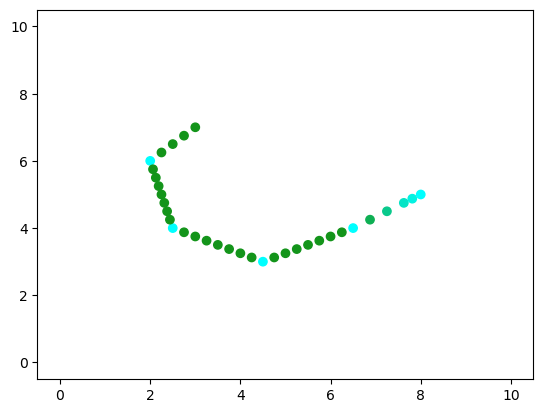

In [12]:
#plot segment lines using data gathered!
plot_x = []
plot_y = []
co = []
for i in rgb_points[:5] + rgb_points[9:len(rgb_points) - len(sp_greens)]:
    plot_x.append(i['point'][0])
    plot_y.append(i['point'][1])
    colr = ()
    if isHsv:
        colr = colorsys.hsv_to_rgb(i['colour'][0], i['colour'][1], i['colour'][2])
    else:
        colr = (i['colour'][0], i['colour'][1], i['colour'][2])
    co.append(colr)

plt.scatter(plot_x, plot_y, c=co)

In [13]:
vm = [i for i in all_dots_indexed]

#Write vertex-colour data onto txt files
vertex_reds = open("vertex_reds.txt", "w")
for point_i in range(len(rgb_points)):
    vertex_reds.write(f"{vm[point_i]} {rgb_points[point_i]['colour'][0]}\n")
vertex_reds.close()

vertex_greens = open("vertex_greens.txt", "w")
for point_i in range(len(rgb_points)):
    vertex_greens.write(f"{vm[point_i]} {rgb_points[point_i]['colour'][1]}\n")
vertex_greens.close()

vertex_blues = open("vertex_blues.txt", "w")
for point_i in range(len(rgb_points)):
    vertex_blues.write(f"{vm[point_i]} {rgb_points[point_i]['colour'][2]}\n")
vertex_blues.close()


#Write mesh generated by triangle onto obj file
obj = open("meshObj.obj", "w")
for point in meshObj['vertices']:
    obj.write(f'v {point[0]} {point[1]}  0\n')
obj.write('\n\n\n\n\n\n')
for triangle in meshObj['triangles']:
    obj.write(f'f {triangle[0] + 1} {triangle[1] + 1} {triangle[2] + 1}\n')
obj.close()

#Set up problems for PolyFEM
reds = {
    "geometry": {
        "mesh": "meshObj.obj"
    },
    "materials": {
        "type": "Laplacian"
    },
    "boundary_conditions": {
        "dirichlet_boundary": [
            "vertex_reds.txt"
        ]
    },
    "output": {
        "paraview": {
            "file_name": "red.vtu"
        }
    }
}

greens = {
    "geometry": {
        "mesh": "meshObj.obj"
    },
    "materials": {
        "type": "Laplacian"
    },
    "boundary_conditions": {
        "dirichlet_boundary": [
            "vertex_greens.txt"
        ]
    },
    "output": {
        "paraview": {
            "file_name": "green.vtu"
        }
    }
}

blues = {
    "geometry": {
        "mesh": "meshObj.obj"
    },
    "materials": {
        "type": "Laplacian"
    },
    "boundary_conditions": {
        "dirichlet_boundary": [
            "vertex_blues.txt"
        ]
    },
    "output": {
        "paraview": {
            "file_name": "blue.vtu"
        }
    }
}


#Dump problems into readable json files
with open("red.json", "w") as fp:
    json.dump(reds, fp)
    
with open("green.json", "w") as fp:
    json.dump(greens, fp)
    
with open("blue.json", "w") as fp:
    json.dump(blues, fp)


#Generate red map for object
command = ["C:\\polyfem\\out\\build\\x64-Debug\\PolyFEM_bin.exe","-j", "red.json"]
p = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

#Generate green map for object
command = ["C:\\polyfem\\out\\build\\x64-Debug\\PolyFEM_bin.exe","-j", "green.json"]
p = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

#Generate blue map for object
command = ["C:\\polyfem\\out\\build\\x64-Debug\\PolyFEM_bin.exe","-j", "blue.json"]
p = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

In [14]:
#Read files generated by PolyFEM
red = meshio.read("red.vtu")
green = meshio.read("green.vtu")
blue = meshio.read("blue.vtu")


#Use reordered faces from one of the files generated by PolyFEM (they're all ordered the same)
face_list = red.cells_dict['triangle']


#Grab generated RGB values and compile into a colour array (co), then convert to mp-readable array with numpy
co = []
for i in range(len(red.points)):
    colr = ()
    if isHsv:
        colr = colorsys.hsv_to_rgb(red.point_data['solution'][i][0], green.point_data['solution'][i][0], blue.point_data['solution'][i][0])
    else:
        colr = (red.point_data['solution'][i][0], green.point_data['solution'][i][0], blue.point_data['solution'][i][0])
    co.append(colr)
col = np.array(co)

In [15]:
#Generate 3D object!
mp.plot(red.points, face_list, c=col, return_plot=True)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0, 5.0,…